In [ ]:
pip install scipy

In [2]:
import scipy.io

# Load the .mat file
mat_contents = scipy.io.loadmat('leukemia.mat')

# Display the contents
#print(mat_contents)
data = mat_contents
X = data['X']
Y=data['Y'].ravel()
print("X =",X)
print("Y =",Y)
print(X.shape[1])
print(data)

X = [[-2  2  0 ...  2  0  0]
 [ 0  0  0 ...  0 -2  0]
 [-2 -2  0 ...  2  0  0]
 ...
 [ 2  2  0 ...  0  0  2]
 [ 0 -2  0 ...  0  0 -2]
 [ 2 -2  0 ...  0  0 -2]]
Y = [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
7070
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Mar 25 15:23:42 2015', '__version__': '1.0', '__globals__': [], 'X': array([[-2,  2,  0, ...,  2,  0,  0],
       [ 0,  0,  0, ...,  0, -2,  0],
       [-2, -2,  0, ...,  2,  0,  0],
       ...,
       [ 2,  2,  0, ...,  0,  0,  2],
       [ 0, -2,  0, ...,  0,  0, -2],
       [ 2, -2,  0, ...,  0,  0, -2]], dtype=int16), 'Y': array([[-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
 

In [ ]:
# import scipy.io

# # # Load the .mat file
# mat_contents = scipy.io.loadmat('leukemia.mat')

# # Display the contents
# #print(mat_contents)
# data = mat_contents
# X = data['X']
# Y=data['Y'].ravel()
# print("X =",X)
# print("Y =",Y)
# print(X.shape[1])
# print(data)

In [ ]:
pip install pymoo

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.termination import get_termination
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)
from pymoo.indicators.hv import HV
import pandas as pd
from pymoo.core.sampling import Sampling
import random
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

In [10]:
X.shape, Y.shape

((72, 7070), (72,))

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42,stratify=Y)

In [5]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((50, 7070), (22, 7070), (50,), (22,))

In [6]:
# Check the distribution of classes
def class_distribution(X):
    unique, counts = np.unique(X, return_counts=True)
    return dict(zip(unique, counts))

# Original dataset distribution
original_dist = class_distribution(X)
print("Original dataset distribution:", original_dist)

# Training set distribution
train_dist = class_distribution(X_train)
print("Training set distribution:", train_dist)

# Test set distribution
test_dist = class_distribution(X_test)
print("Test set distribution:", test_dist)

Original dataset distribution: {-2: 154055, 0: 222325, 2: 132660}
Training set distribution: {-2: 103301, 0: 155763, 2: 94436}
Test set distribution: {-2: 50754, 0: 66562, 2: 38224}


In [7]:
# Check the distribution of classes
def class_distribution(Y):
    unique, counts = np.unique(Y, return_counts=True)
    return dict(zip(unique, counts))

# Original dataset distribution
original_dist = class_distribution(Y)
print("Original dataset distribution:", original_dist)

# Training set distribution
train_dist = class_distribution(Y_train)
print("Training set distribution:", train_dist)

# Test set distribution
test_dist = class_distribution(Y_test)
print("Test set distribution:", test_dist)

Original dataset distribution: {-1: 47, 1: 25}
Training set distribution: {-1: 33, 1: 17}
Test set distribution: {-1: 14, 1: 8}


In [274]:
print(X_train)
print(Y_train)

[[-2 -2  2 ...  0  0 -2]
 [ 2  0  0 ...  2  0  2]
 [ 2  2  2 ... -2 -2 -2]
 ...
 [-2  0 -2 ...  0 -2  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0 -2 ...  0  0  2]]
[-1  1 -1 -1  1  1  1 -1  1  1  1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1
 -1 -1  1 -1 -1  1 -1 -1 -1  1 -1  1 -1 -1 -1  1 -1 -1 -1 -1  1 -1  1  1
 -1 -1]


In [64]:
class MyProblem(Problem):
    def __init__(self):
        super().__init__(n_var=7070, # decision variables
                         n_obj=2,  # two objective functions
                        n_ieq_constr=1 
                        )

    def _classification_error(self, bitstring):
        featureNames = []
        for i in range(len(bitstring)):
            if bitstring[i] == 1:
                featureNames.append(i)
  
        if len(featureNames) == 0:
            return 1
        else:
            trainx = X_train[:,featureNames]
            trainy = Y_train
            knn = KNeighborsClassifier(n_neighbors=5)
            knn.fit(trainx, trainy)
            Y_pred = knn.predict(trainx)
            ac = accuracy_score(trainy, Y_pred)
            return 1 - ac

    def _features_number(self, bitstring):
        return sum(bitstring)

    def _constrain(self,bitstring):
        return 1 - sum(bitstring)
    
    def _evaluate(self, x, out, *args, **kwargs):
        f1 = [self._features_number(x[i]) for i in range(len(x))]
        f2 = [self._classification_error(x[i]) for i in range(len(x))]
        g1 = [self._constrain(x[i]) for i in range(0, len(x))]
        out["F"] = np.column_stack([f1, f2])
        out["G"] = np.column_stack([g1])

In [65]:
class generate_population(Sampling):
        def __init__(self):
            super().__init__()
            
        def _do(self, problem, n_samples, **kwargs):
            total_features = 7070
            population_size = 100
            population = []
            for _ in range(population_size):
                n = random.randint(1, total_features) 
                individual = [0] * total_features
                selected_indices = random.sample(range(total_features), n)
                for idx in selected_indices :
                    individual[idx] = 1
                population.append(individual)
            return population

In [66]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size=0.3, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(xtrain, ytrain)
ypred = knn.predict(xtrain)
ac = accuracy_score(ytrain, ypred)
print("Classification error on training sets using all features: " + str(1 - ac))
ypred = knn.predict(xtest)
ac = accuracy_score(ytest, ypred)
print("Classification error on testing sets using all features: " + str(1 - ac))

print("###################################################################################")

Classification error on training sets using all features: 0.06000000000000005
Classification error on testing sets using all features: 0.09090909090909094
###################################################################################


In [67]:
#problem = FeatureSelectionProblem(X,Y)


In [68]:
problem = MyProblem()

In [69]:
algorithm = NSGA2(pop_size=100,
                  sampling=generate_population(),
                  crossover=UniformCrossover(prob=0.9),
                  mutation=BitflipMutation(prob=0.01),
                  eliminate_duplicates=True)

In [70]:
termination = get_termination("n_gen", 30)

In [71]:
res = minimize(problem,
               algorithm,
               termination,
               seed=42,
               save_history=True,
               verbose=True)

i_f = res.history[0].opt.get("F")
i_pop = res.history[0].pop
f = res.F
pop = res.pop
solutions = res.X

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      4 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |      4 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     3 |      300 |      4 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     4 |      400 |      4 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     5 |      500 |      4 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     6 |      600 |      5 |  0.000000E+00 |  0.000000E+00 |  0.1000000000 |         ideal
     7 |      700 |      5 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     8 |      800 |      5 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     9 |      900 |      5 |  0.000000E+00 |  0.000000E+00 |  0.2369597615 |         nadir
    10 |     1000 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0668007174 |             f

the intial pareto front is plotted as: 


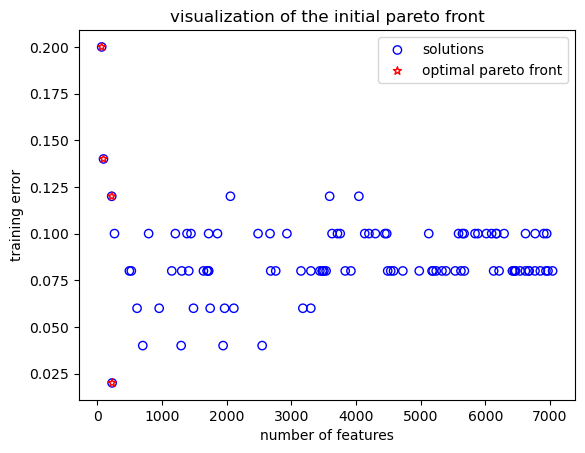

the final pareto front is plotted as: 


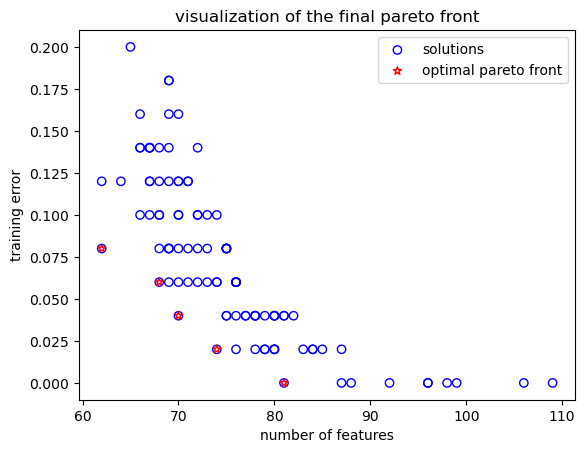

In [72]:
print("the intial pareto front is plotted as: ")
plt.scatter(i_pop.get("F")[:,0], i_pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
plt.scatter(i_f[:,0], i_f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
plt.xlabel('number of features')
plt.ylabel('training error')
plt.legend()
plt.title("visualization of the initial pareto front")
plt.show()
print("the final pareto front is plotted as: ")
plt.scatter(pop.get("F")[:,0], pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
plt.scatter(f[:,0], f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
plt.xlabel('number of features')
plt.ylabel('training error')
plt.legend()
plt.title("visualization of the final pareto front")
plt.show()

In [213]:
print(res.F[:,1])
print(res.F[:,0])
print(pop.get("F")[:,0])
print(pop.get("F")[:,1])

[0.   0.2  0.   0.02]
[6. 1. 6. 2.]
[ 6.  1.  6.  2.  1.  7.  4.  2.  2.  4.  8.  8.  8.  8.  2.  3.  3.  5.
  5.  4.  4.  5.  4.  9.  9.  2.  3.  3.  3.  6.  6.  6.  6.  6.  6.  6.
  6.  4.  5.  5.  5.  4.  5.  4.  5.  4. 10. 10. 10.  2.  3.  3.  3.  3.
  3.  7.  7.  7.  7.  7.  7.  6.  6.  6.  6.  6.  6.  6.  6.  6.  4.  4.
  4.  5.  5.  5.  5.  4.  5.  5. 11. 11.  2.  2.  2.  2.  3.  8.  8.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  7.  7.  7.  7.  7.  7.  7.  7.  7.  7.
  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.  6.  6.  6.  6.  6.  6.  6.  5.
  6.  5.  6. 12. 12. 12. 12. 12. 12.  2.  3.  9.  9.  9.  9.  9.  9.  9.
  9.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  4.  4.  4.  4.
  4.  4.  5.  5.  5.  5.  5.  6.  6.  6.  6.  7.  7.  7.  7.  6.  7.  6.
  6.  7.  6.  6.  7.  7.  7.  6.  7.  6.  7.  6.  6.  2.  2. 13. 13.  3.
 10.  9.]
[0.   0.2  0.   0.02 0.28 0.   0.02 0.06 0.06 0.02 0.   0.   0.   0.
 0.1  0.06 0.06 0.02 0.02 0.04 0.04 0.02 0.04 0.   0.   0.14 0.08 0.08
 0.08 0.02 

In [120]:
def evaluate_on_test(X_test, Y_test, solution):
    feature_indices = [i for i in range(len(solution)) if solution[i] == 1]
    if len(feature_indices) == 0:
        return [X.shape[1], 1.0]
    else:
        X_test_selected = X_test[:, feature_indices]
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train[:, feature_indices], Y_train)
        Y_pred = knn.predict(X_test_selected)
        error_rate = 1 - accuracy_score(Y_test, Y_pred)
        return [len(feature_indices), error_rate]

The final Pareto front is plotted as:


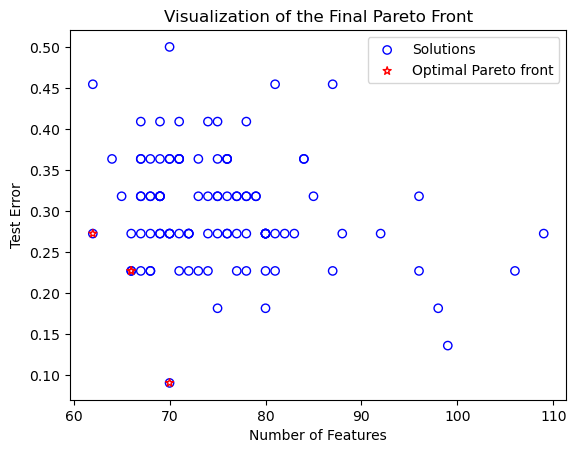

In [121]:
# Evaluate each solution on the test data
Solutions_test = np.array([evaluate_on_test(X_test, Y_test, solution) for solution in pop.get("X")])

# Perform non-dominated sorting
nds = NonDominatedSorting().do(Solutions_test)

# Extract the Pareto front solutions
pareto_front_indices = nds[0]
pareto_front_objectives = Solutions_test[pareto_front_indices]


# print(f"Total number of solutions: {len(Solutions_test)}")
# print(f"Number of Pareto front solutions: {len(pareto_front_indices)}")
# print("Some solutions from the last generation:", Solutions_test[:5])
# print("Pareto front solutions:", pareto_front_objectives)


# Plot the Pareto front graph
print("The final Pareto front is plotted as:")
plt.scatter(Solutions_test[:, 0], Solutions_test[:, 1], edgecolor="blue", facecolor="none", label="Solutions")
plt.scatter(pareto_front_objectives[:, 0], pareto_front_objectives[:, 1], marker='*', edgecolor="red", facecolor="none", label="Optimal Pareto front")
plt.xlabel('Number of Features')
plt.ylabel('Test Error')
plt.legend()
plt.title("Visualization of the Final Pareto Front")
plt.show()

In [ ]:
# Plot the Pareto front for test data
import matplotlib.pyplot as plt

plt.scatter(f_test[:, 0], f_test[:, 1], edgecolor="blue", facecolor="none", label="Test Data Pareto Front")
plt.scatter(optimal_solution[0], optimal_solution[1], marker='*', color='red', s=100, label="Optimal Solution")
plt.xlabel('Number of Features')
plt.ylabel('Error Rate')
plt.legend()
plt.title("Pareto Front on Test Data")
plt.show()

In [ ]:
ref_point = np.array([1, 1])
ind = HV(ref_point=ref_point)
scaler = MinMaxScaler()
f_train = scaler.fit_transform(f)
hv_train = ind(f_train)
print("HV of the best pareto front train:" + str(round(hv_train, 2)))

In [ ]:
ref_point = np.array([1, 1])
ind = HV(ref_point=ref_point)
scaler = MinMaxScaler()
f_t = scaler.fit_transform(f_test)
hv_test = ind(f_t)
print("HV of the best pareto front test:" + str(round(hv_test, 2)))

In [ ]:
# Extracting and plotting the Pareto Front from all generations
pareto_fronts = [gen.opt.get("F") for gen in res.history]

for i, pareto in enumerate(pareto_fronts):
    plt.scatter(pareto[:, 0], pareto[:, 1])

plt.xlabel('Number of Features')
plt.ylabel('Training Error Rate')
plt.title('Pareto Front Evolution')
plt.legend()
plt.show()



In [ ]:
print("the intial pareto front is plotted as: ")
plt.scatter(i_pop.get("F")[:,0], i_pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
plt.scatter(i_f[:,0], i_f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
plt.xlabel('number of features')
plt.ylabel('training error')
plt.legend()
plt.title("visualization of the initial pareto front")
plt.show()


In [ ]:
print("the final pareto front is plotted as: ")
plt.scatter(pop.get("F")[:,0], pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
plt.scatter(f[:,0], f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
plt.xlabel('number of features')
plt.ylabel('training error')
plt.legend()
plt.title("visualization of the final pareto front")
plt.show()

In [ ]:
print("the final pareto front is plotted as: ")
#Train data
plt.scatter(pop.get("F")[:,0], pop.get("F")[:,1], edgecolor="blue", facecolor="none", label="Training Solutions")
plt.scatter(f[:,0], f[:,1], marker='*', edgecolor="red", facecolor="none", label="Optimal Pareto Front (Training)")
#Test data
plt.scatter(f_test[:, 0], f_test[:, 1], edgecolor="blue", facecolor="none", label="Test Data Pareto Front")
plt.scatter(optimal_solution[0], optimal_solution[1], marker='*', color='red', s=100, label="Optimal Solution(Testing)")

plt.xlabel('Number of Features')
plt.ylabel('Training Error')
plt.legend()
plt.title("Visualization of the Final Pareto Front (Training and Test)")
plt.show()

In [ ]:
# Get the minimum error from the optimization result
min_error_train = np.min(res.F[:, 1])

# Print the minimum error
print("Minimum error on training dataset:", min_error_train)

In [ ]:
# Get the minimum error from the optimization result
min_error_test = np.min(f_test[:,1])

# Print the minimum error
print("Minimum error on testing dataset:", min_error_test)

In [ ]:
# Get the minimum error from the optimization result
min_error_train = np.min(res.F[:, 1])

# Find the row(s) where the error is minimized
min_error_indices = np.where(res.F[:, 1] == min_error_train)[0]

# Get the corresponding solutions with minimum error
solutions_with_min_error = res.X[min_error_indices]

# Get the number of features for the solutions with minimum error
num_features_with_min_error_train = [np.count_nonzero(solution) for solution in solutions_with_min_error]

# Print the number of features with minimum error
print("Number of features with minimum error on train:", num_features_with_min_error_train)

In [ ]:
num_features_with_min_error_test = optimal_solution[0]
print("Number of features with minimum error on test data:",num_features_with_min_error_test)

In [ ]:
from prettytable import PrettyTable

# Create a PrettyTable instance
table = PrettyTable()

# Set the column alignment
table.align = "l"

# Define the column names
table.field_names = ["Info abt. Dataset(Name,SampleSize,Features)", "H.V.(Train)", "H.V.(Test)", 
                     "Min. Error(Train)", "Min. Error(Test)", "Feat. with Min. Error (Train)", 
                     "Feat. with Min. Error (Test)"]

# Populate the table with data
dataset_info = "Colon,62,2000"
hv_training = "{:.2f}".format(hv_train)
hv_testing = "{:.2f}".format(hv_test)
min_error_training = "{:.5f}".format(min_error_train)
min_error_testing = "{:.5f}".format(min_error_test)
min_error_features_training = num_features_with_min_error_train[0]
min_error_features_testing = num_features_with_min_error_test
samplesize = "62"
features = "2000"

# Add data to the table row
table.add_row([dataset_info, hv_training, hv_testing, min_error_training, min_error_testing,
               min_error_features_training, min_error_features_testing])


# Print the table
print(table)


# (TRAIN + Validation ) For Voting




In [13]:
X_train1, X_valid1, Y_train1, Y_valid1 = train_test_split(X_train, Y_train, test_size=0.3, random_state=42,stratify=Y_train)

In [15]:
X_train1.shape, X_valid1.shape, Y_train1.shape, Y_valid1.shape

((35, 7070), (15, 7070), (35,), (15,))

In [137]:
class MyProblem_Split(Problem):
    def __init__(self):
        super().__init__(n_var=7070, # decision variables
                         n_obj=2,  # two objective functions
                        n_ieq_constr=1 
                        )

    def _classification_error(self, bitstring):
        featureNames = []
        for i in range(len(bitstring)):
            if bitstring[i] == 1:
                featureNames.append(i)
  
        if len(featureNames) == 0:
            return 1
        else:
            trainx = X_train1[:,featureNames]
            trainy = Y_train1
            knn = KNeighborsClassifier(n_neighbors=5)
            knn.fit(trainx, trainy)
            Y_pred = knn.predict(trainx)
            ac = accuracy_score(trainy, Y_pred)
            return 1 - ac

    def _features_number(self, bitstring):
        return sum(bitstring)

    def _constrain(self,bitstring):
        return 1 - sum(bitstring)
    
    def _evaluate(self, x, out, *args, **kwargs):
        f1 = [self._features_number(x[i]) for i in range(len(x))]
        f2 = [self._classification_error(x[i]) for i in range(len(x))]
        g1 = [self._constrain(x[i]) for i in range(0, len(x))]
        out["F"] = np.column_stack([f1, f2])
        out["G"] = np.column_stack([g1])

In [138]:
problem_split = MyProblem_Split()

In [139]:
algorithm = NSGA2(pop_size=100,
                  sampling=generate_population(),
                  crossover=UniformCrossover(prob=0.9),
                  mutation=BitflipMutation(prob=0.01),
                  eliminate_duplicates=True)

In [140]:
termination = get_termination("n_gen", 30)

In [141]:
res = minimize(problem_split,
               algorithm,
               termination,
               seed=42,
               save_history=True,
               verbose=True)

i_f = res.history[0].opt.get("F")
i_pop = res.history[0].pop
f = res.F
pop = res.pop
pop_valid = res.pop
solutions = res.X

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      4 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |      4 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     3 |      300 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0005470460 |             f
     4 |      400 |      3 |  0.000000E+00 |  0.000000E+00 |  0.4135802469 |         nadir
     5 |      500 |      4 |  0.000000E+00 |  0.000000E+00 |  0.1428571429 |         ideal
     6 |      600 |      4 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     7 |      700 |      5 |  0.000000E+00 |  0.000000E+00 |  0.1250000000 |         ideal
     8 |      800 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0781283360 |             f
     9 |      900 |      5 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    10 |     1000 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0363161206 |             f

the intial pareto front is plotted as: 


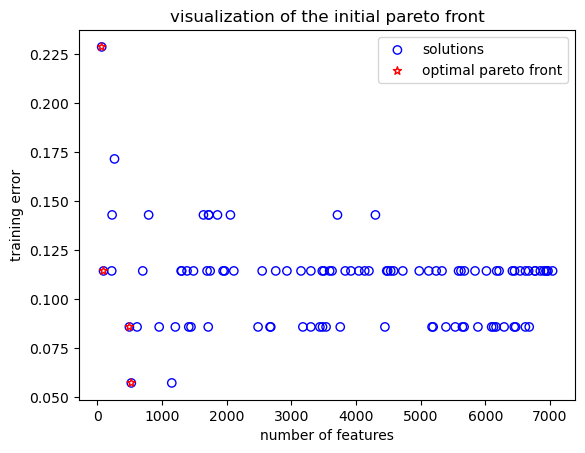

the final pareto front is plotted as: 


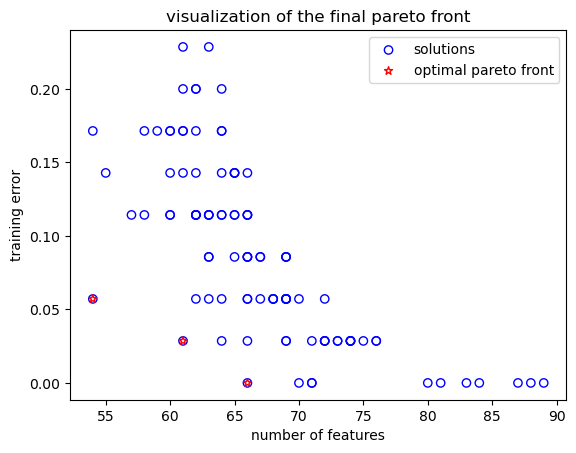

In [142]:
print("the intial pareto front is plotted as: ")
plt.scatter(i_pop.get("F")[:,0], i_pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
plt.scatter(i_f[:,0], i_f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
plt.xlabel('number of features')
plt.ylabel('training error')
plt.legend()
plt.title("visualization of the initial pareto front")
plt.show()
print("the final pareto front is plotted as: ")
plt.scatter(pop.get("F")[:,0], pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
plt.scatter(f[:,0], f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
plt.xlabel('number of features')
plt.ylabel('training error')
plt.legend()
plt.title("visualization of the final pareto front")
plt.show()

In [143]:
def evaluate_on_valid_data(X, Y, solution):
    feature_indices = [i for i in range(len(solution)) if solution[i] == 1]
    if len(feature_indices) == 0:
        return [X_test.shape[1], 1.0]
    else:
        X_test_selected = X[:, feature_indices]
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train1[:, feature_indices], Y_train1)
        Y_pred = knn.predict(X_test_selected)
        error_rate = 1 - accuracy_score(Y, Y_pred)
        return [len(feature_indices), error_rate]

The final Pareto front is plotted as:


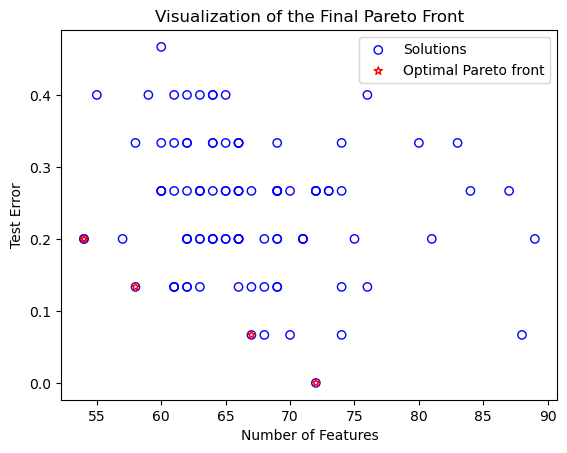

In [144]:
# Evaluate each solution on the test data
Solutions_valid = np.array([evaluate_on_valid_data(X_valid1, Y_valid1, solution) for solution in pop_valid.get("X")])

# Perform non-dominated sorting
nds = NonDominatedSorting().do(Solutions_valid)

# Extract the Pareto front solutions
pareto_front_indices = nds[0]
pareto_front_objectives = Solutions_valid[pareto_front_indices]

# Plot the Pareto front graph
print("The final Pareto front is plotted as:")
plt.scatter(Solutions_valid[:, 0], Solutions_valid[:, 1], edgecolor="blue", facecolor="none", label="Solutions")
plt.scatter(pareto_front_objectives[:, 0], pareto_front_objectives[:, 1], marker='*', edgecolor="red", facecolor="none", label="Optimal Pareto front")
plt.xlabel('Number of Features')
plt.ylabel('Test Error')
plt.legend()
plt.title("Visualization of the Final Pareto Front")
plt.show()